# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)


Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

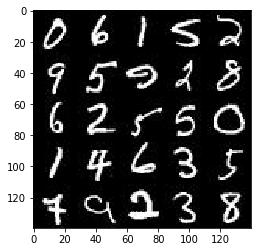

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

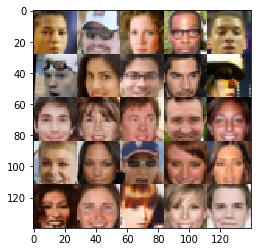

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    
    input_real = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name="input_real")
    input_z = tf.placeholder(tf.float32, (None, z_dim), "input_z")
    learning_rate = tf.placeholder(tf.float32, (), name="learning_rate")

    return input_real, input_z, learning_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha= 0.01):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope("discriminator", reuse=reuse):
        
        weights = tf.contrib.layers.xavier_initializer_conv2d()
        
        # entrada 28*28*3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, 
                              padding="same")
        
        relu1 = tf.maximum(x1 * alpha, x1)
        # saída 14*14*64
        
        x2 = tf.layers.conv2d(relu1, 128, 8, strides=2, 
                              padding="same",
                              kernel_initializer = weights)
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(bn2 * alpha, bn2)
        #saída 7*7*128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, 
                              padding="same",
                              kernel_initializer = weights)
        
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(bn3 * alpha, bn3)
        #saída 4*4*256
        
        # Reshaping para achatar cada entrada em um único array
        flat = tf.reshape(relu3, (-1, 4*4*256))

        # implementando a rede totalmente conectada
        logits = tf.layers.dense(flat, 1)
        
        # utilizando a ativação sigmoid e obtendo a saída final desejada
        output = tf.sigmoid(logits)    
    

    return logits, output

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

/home/leonardo/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        
        alpha=0.2
        
        weights = tf.contrib.layers.xavier_initializer_conv2d()
        
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x512
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2,
                                        padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=1,
                                        padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 28x28x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5,
                                            strides=2, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, 
                                                reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_real, 
            labels=tf.ones_like(d_model_real)))
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake,
            labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake, 
            labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    
    d_vars = [var for var in t_vars 
              if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars 
              if var.name.startswith('generator')]
    d_train_opt = tf.train.AdamOptimizer(learning_rate, 
                                         beta1=beta1).minimize(d_loss, var_list=d_vars)
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_updates = [opt for opt in update_ops if opt.name.startswith('generator')]    
    # Optimize
    with tf.control_dependencies(g_updates):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, 
                                             beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:


def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, width, height, channels = data_shape
    
    input_real, input_z, lr = model_inputs(width, height, channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    # instanciando o saver
    saver = tf.train.Saver()
    
    #inicializando o contador de steps
    steps = 0
    
    with tf.Session() as sess:
        # Inicializando a variáveis do grafo
        sess.run(tf.global_variables_initializer())
        
        # Loop por N epocas
        for epoch_i in range(epoch_count):
            
            # Chamando os mini-lotes
            for batch_images in get_batches(batch_size):
                # Adicionando1 a cada interação
                steps += 1
                
                # batch_images = batch_images * 2
                
                # criando um sample randomico para o ruído do gerador
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Rodando os otimizadores
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})

                if steps % 10 == 0:
                    # imprimir a cada 100 steps
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    # Imprimindo os valores da interação
                    print("Época {}/{}..., etapa {}".format(epoch_i+1, epochs, steps),
                          "Perca do Discriminante: {:.4f}...".format(train_loss_d),
                          "Percado do Gerador: {:.4f}".format(train_loss_g))
                
                # printando a imagens geradas pelo modelo
                if steps % 100 == 0:
                    show_generator_output(sess, 16, input_z, channels, data_image_mode)
        
        # Salvando o modelo
        saver.save(sess, './generator.ckpt')

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

(60000, 28, 28, 1)
Época 1/2..., etapa 10 Perca do Discriminante: 1.0067... Percado do Gerador: 0.6931
Época 1/2..., etapa 20 Perca do Discriminante: 1.0067... Percado do Gerador: 0.6931
Época 1/2..., etapa 30 Perca do Discriminante: 1.0065... Percado do Gerador: 0.6931
Época 1/2..., etapa 40 Perca do Discriminante: 1.0064... Percado do Gerador: 0.6931
Época 1/2..., etapa 50 Perca do Discriminante: 1.0065... Percado do Gerador: 0.6931
Época 1/2..., etapa 60 Perca do Discriminante: 1.0064... Percado do Gerador: 0.6931
Época 1/2..., etapa 70 Perca do Discriminante: 1.0064... Percado do Gerador: 0.6931
Época 1/2..., etapa 80 Perca do Discriminante: 1.0064... Percado do Gerador: 0.6931
Época 1/2..., etapa 90 Perca do Discriminante: 1.0064... Percado do Gerador: 0.6931
Época 1/2..., etapa 100 Perca do Discriminante: 1.0064... Percado do Gerador: 0.6931


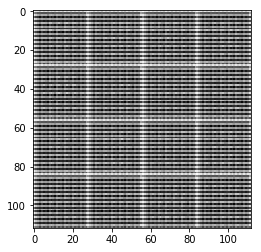

Época 1/2..., etapa 110 Perca do Discriminante: 1.0064... Percado do Gerador: 0.6931
Época 1/2..., etapa 120 Perca do Discriminante: 1.0064... Percado do Gerador: 0.6931
Época 1/2..., etapa 130 Perca do Discriminante: 1.0064... Percado do Gerador: 0.6931
Época 1/2..., etapa 140 Perca do Discriminante: 1.0064... Percado do Gerador: 0.6931
Época 1/2..., etapa 150 Perca do Discriminante: 1.0065... Percado do Gerador: 0.6931
Época 1/2..., etapa 160 Perca do Discriminante: 1.0064... Percado do Gerador: 0.6931
Época 1/2..., etapa 170 Perca do Discriminante: 1.0064... Percado do Gerador: 0.6931
Época 1/2..., etapa 180 Perca do Discriminante: 1.0064... Percado do Gerador: 0.6931
Época 1/2..., etapa 190 Perca do Discriminante: 1.0064... Percado do Gerador: 0.6931
Época 1/2..., etapa 200 Perca do Discriminante: 1.0064... Percado do Gerador: 0.6931


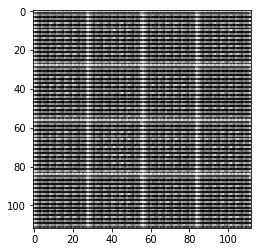

Época 1/2..., etapa 210 Perca do Discriminante: 1.0064... Percado do Gerador: 0.6931
Época 1/2..., etapa 220 Perca do Discriminante: 1.0064... Percado do Gerador: 0.6931
Época 1/2..., etapa 230 Perca do Discriminante: 1.0258... Percado do Gerador: 0.6803
Época 1/2..., etapa 240 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/2..., etapa 250 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/2..., etapa 260 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/2..., etapa 270 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/2..., etapa 280 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/2..., etapa 290 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/2..., etapa 300 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133


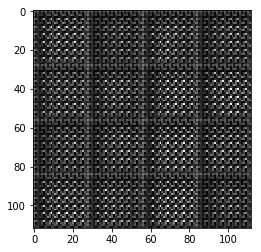

Época 1/2..., etapa 310 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/2..., etapa 320 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/2..., etapa 330 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/2..., etapa 340 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/2..., etapa 350 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/2..., etapa 360 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/2..., etapa 370 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/2..., etapa 380 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/2..., etapa 390 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/2..., etapa 400 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133


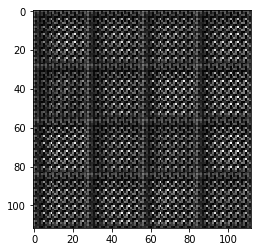

Época 1/2..., etapa 410 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/2..., etapa 420 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/2..., etapa 430 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/2..., etapa 440 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/2..., etapa 450 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/2..., etapa 460 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/2..., etapa 470 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/2..., etapa 480 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/2..., etapa 490 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/2..., etapa 500 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133


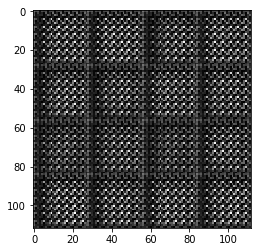

Época 1/2..., etapa 510 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/2..., etapa 520 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/2..., etapa 530 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/2..., etapa 540 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/2..., etapa 550 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/2..., etapa 560 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/2..., etapa 570 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/2..., etapa 580 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/2..., etapa 590 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/2..., etapa 600 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133


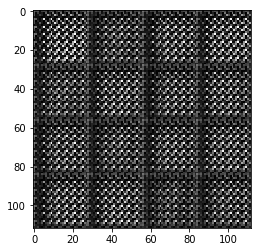

Época 1/2..., etapa 610 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/2..., etapa 620 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/2..., etapa 630 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/2..., etapa 640 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/2..., etapa 650 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/2..., etapa 660 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/2..., etapa 670 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/2..., etapa 680 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/2..., etapa 690 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/2..., etapa 700 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133


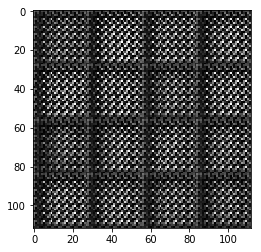

Época 1/2..., etapa 710 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/2..., etapa 720 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/2..., etapa 730 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/2..., etapa 740 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/2..., etapa 750 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/2..., etapa 760 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/2..., etapa 770 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/2..., etapa 780 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/2..., etapa 790 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/2..., etapa 800 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133


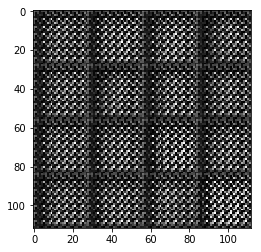

Época 1/2..., etapa 810 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/2..., etapa 820 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/2..., etapa 830 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/2..., etapa 840 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/2..., etapa 850 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/2..., etapa 860 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/2..., etapa 870 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/2..., etapa 880 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/2..., etapa 890 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/2..., etapa 900 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133


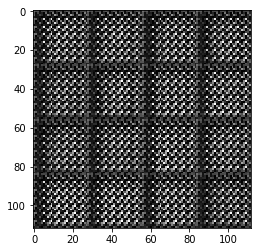

Época 1/2..., etapa 910 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/2..., etapa 920 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/2..., etapa 930 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 2/2..., etapa 940 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 2/2..., etapa 950 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 2/2..., etapa 960 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 2/2..., etapa 970 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 2/2..., etapa 980 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 2/2..., etapa 990 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 2/2..., etapa 1000 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133


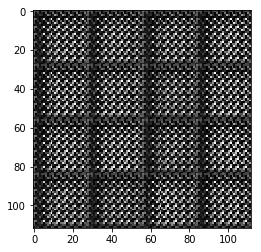

Época 2/2..., etapa 1010 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 2/2..., etapa 1020 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 2/2..., etapa 1030 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 2/2..., etapa 1040 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 2/2..., etapa 1050 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 2/2..., etapa 1060 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 2/2..., etapa 1070 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 2/2..., etapa 1080 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 2/2..., etapa 1090 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 2/2..., etapa 1100 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133


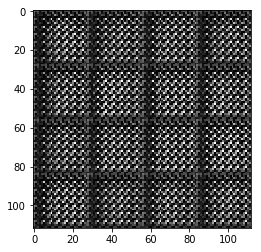

Época 2/2..., etapa 1110 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 2/2..., etapa 1120 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 2/2..., etapa 1130 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 2/2..., etapa 1140 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 2/2..., etapa 1150 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 2/2..., etapa 1160 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 2/2..., etapa 1170 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 2/2..., etapa 1180 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 2/2..., etapa 1190 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 2/2..., etapa 1200 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133


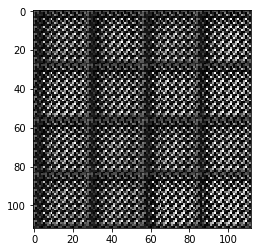

Época 2/2..., etapa 1210 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 2/2..., etapa 1220 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 2/2..., etapa 1230 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 2/2..., etapa 1240 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 2/2..., etapa 1250 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 2/2..., etapa 1260 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 2/2..., etapa 1270 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 2/2..., etapa 1280 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 2/2..., etapa 1290 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 2/2..., etapa 1300 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133


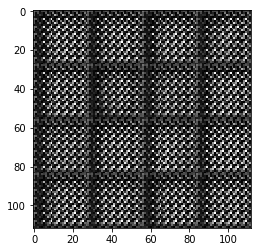

Época 2/2..., etapa 1310 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 2/2..., etapa 1320 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 2/2..., etapa 1330 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 2/2..., etapa 1340 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 2/2..., etapa 1350 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 2/2..., etapa 1360 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 2/2..., etapa 1370 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 2/2..., etapa 1380 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 2/2..., etapa 1390 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 2/2..., etapa 1400 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133


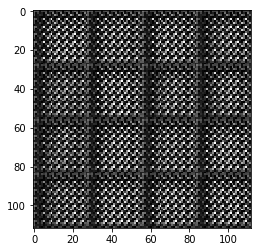

Época 2/2..., etapa 1410 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 2/2..., etapa 1420 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 2/2..., etapa 1430 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 2/2..., etapa 1440 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 2/2..., etapa 1450 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 2/2..., etapa 1460 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 2/2..., etapa 1470 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 2/2..., etapa 1480 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 2/2..., etapa 1490 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 2/2..., etapa 1500 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133


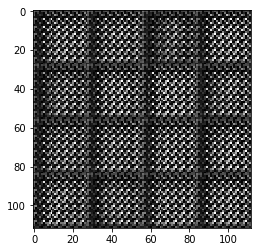

Época 2/2..., etapa 1510 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 2/2..., etapa 1520 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 2/2..., etapa 1530 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 2/2..., etapa 1540 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 2/2..., etapa 1550 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 2/2..., etapa 1560 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 2/2..., etapa 1570 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 2/2..., etapa 1580 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 2/2..., etapa 1590 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 2/2..., etapa 1600 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133


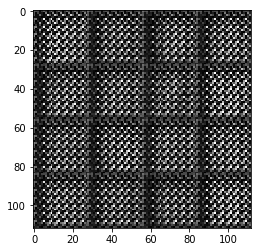

Época 2/2..., etapa 1610 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 2/2..., etapa 1620 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 2/2..., etapa 1630 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 2/2..., etapa 1640 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 2/2..., etapa 1650 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 2/2..., etapa 1660 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 2/2..., etapa 1670 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 2/2..., etapa 1680 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 2/2..., etapa 1690 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 2/2..., etapa 1700 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133


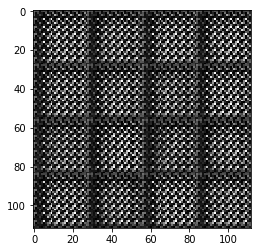

Época 2/2..., etapa 1710 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 2/2..., etapa 1720 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 2/2..., etapa 1730 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 2/2..., etapa 1740 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 2/2..., etapa 1750 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 2/2..., etapa 1760 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 2/2..., etapa 1770 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 2/2..., etapa 1780 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 2/2..., etapa 1790 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 2/2..., etapa 1800 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133


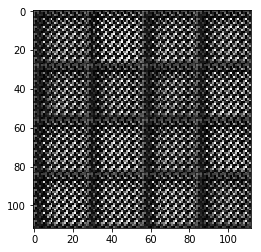

Época 2/2..., etapa 1810 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 2/2..., etapa 1820 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 2/2..., etapa 1830 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 2/2..., etapa 1840 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 2/2..., etapa 1850 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 2/2..., etapa 1860 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 2/2..., etapa 1870 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133


In [12]:
batch_size = 64
z_dim = 128
learning_rate = 0.0003
beta1 = 0.001


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2
tf.reset_default_graph()
mnist_dataset = helper.Dataset('mnist', 
                               glob(os.path.join(data_dir, 
                                                 'mnist/*.jpg')))

print(mnist_dataset.shape)

with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, 
          beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, 
          mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Época 1/1..., etapa 10 Perca do Discriminante: 1.1744... Percado do Gerador: 0.6931
Época 1/1..., etapa 20 Perca do Discriminante: 1.2268... Percado do Gerador: 0.6931
Época 1/1..., etapa 30 Perca do Discriminante: 1.0079... Percado do Gerador: 0.6931
Época 1/1..., etapa 40 Perca do Discriminante: 1.0066... Percado do Gerador: 0.6931
Época 1/1..., etapa 50 Perca do Discriminante: 1.0067... Percado do Gerador: 0.6931
Época 1/1..., etapa 60 Perca do Discriminante: 1.0065... Percado do Gerador: 0.6931
Época 1/1..., etapa 70 Perca do Discriminante: 1.0064... Percado do Gerador: 0.6931
Época 1/1..., etapa 80 Perca do Discriminante: 1.0064... Percado do Gerador: 0.6931
Época 1/1..., etapa 90 Perca do Discriminante: 1.0064... Percado do Gerador: 0.6931
Época 1/1..., etapa 100 Perca do Discriminante: 1.0066... Percado do Gerador: 0.6931


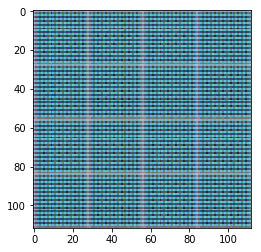

Época 1/1..., etapa 110 Perca do Discriminante: 1.0064... Percado do Gerador: 0.6931
Época 1/1..., etapa 120 Perca do Discriminante: 1.0064... Percado do Gerador: 0.6931
Época 1/1..., etapa 130 Perca do Discriminante: 1.0064... Percado do Gerador: 0.6931
Época 1/1..., etapa 140 Perca do Discriminante: 1.0065... Percado do Gerador: 0.6931
Época 1/1..., etapa 150 Perca do Discriminante: 1.0064... Percado do Gerador: 0.6931
Época 1/1..., etapa 160 Perca do Discriminante: 1.0064... Percado do Gerador: 0.6931
Época 1/1..., etapa 170 Perca do Discriminante: 1.0064... Percado do Gerador: 0.6931
Época 1/1..., etapa 180 Perca do Discriminante: 1.0064... Percado do Gerador: 0.6931
Época 1/1..., etapa 190 Perca do Discriminante: 1.0067... Percado do Gerador: 0.6931
Época 1/1..., etapa 200 Perca do Discriminante: 1.0064... Percado do Gerador: 0.6931


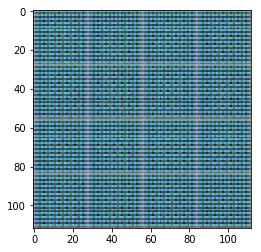

Época 1/1..., etapa 210 Perca do Discriminante: 1.0064... Percado do Gerador: 0.6931
Época 1/1..., etapa 220 Perca do Discriminante: 1.0064... Percado do Gerador: 0.6931
Época 1/1..., etapa 230 Perca do Discriminante: 1.0064... Percado do Gerador: 0.6931
Época 1/1..., etapa 240 Perca do Discriminante: 1.0064... Percado do Gerador: 0.6931
Época 1/1..., etapa 250 Perca do Discriminante: 1.0064... Percado do Gerador: 0.6931
Época 1/1..., etapa 260 Perca do Discriminante: 1.0064... Percado do Gerador: 0.6931
Época 1/1..., etapa 270 Perca do Discriminante: 1.0064... Percado do Gerador: 0.6931
Época 1/1..., etapa 280 Perca do Discriminante: 1.0064... Percado do Gerador: 0.6931
Época 1/1..., etapa 290 Perca do Discriminante: 1.0064... Percado do Gerador: 0.6931
Época 1/1..., etapa 300 Perca do Discriminante: 1.0064... Percado do Gerador: 0.6931


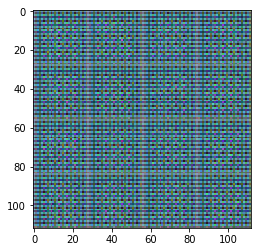

Época 1/1..., etapa 310 Perca do Discriminante: 1.0064... Percado do Gerador: 0.6931
Época 1/1..., etapa 320 Perca do Discriminante: 1.3863... Percado do Gerador: 0.6931
Época 1/1..., etapa 330 Perca do Discriminante: 1.3863... Percado do Gerador: 0.6931
Época 1/1..., etapa 340 Perca do Discriminante: 1.3863... Percado do Gerador: 0.6931
Época 1/1..., etapa 350 Perca do Discriminante: 1.3863... Percado do Gerador: 0.6931
Época 1/1..., etapa 360 Perca do Discriminante: 1.3863... Percado do Gerador: 0.6931
Época 1/1..., etapa 370 Perca do Discriminante: 1.3863... Percado do Gerador: 0.6931
Época 1/1..., etapa 380 Perca do Discriminante: 1.3862... Percado do Gerador: 0.6931
Época 1/1..., etapa 390 Perca do Discriminante: 1.3854... Percado do Gerador: 0.6931
Época 1/1..., etapa 400 Perca do Discriminante: 1.0064... Percado do Gerador: 0.6931


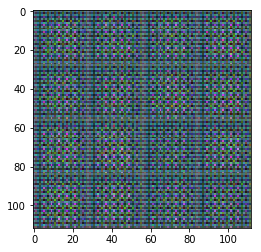

Época 1/1..., etapa 410 Perca do Discriminante: 1.0066... Percado do Gerador: 0.6931
Época 1/1..., etapa 420 Perca do Discriminante: 1.0065... Percado do Gerador: 0.6931
Época 1/1..., etapa 430 Perca do Discriminante: 1.0064... Percado do Gerador: 0.6931
Época 1/1..., etapa 440 Perca do Discriminante: 1.0064... Percado do Gerador: 0.6931
Época 1/1..., etapa 450 Perca do Discriminante: 1.0064... Percado do Gerador: 0.6931
Época 1/1..., etapa 460 Perca do Discriminante: 1.0064... Percado do Gerador: 0.6931
Época 1/1..., etapa 470 Perca do Discriminante: 1.0064... Percado do Gerador: 0.6931
Época 1/1..., etapa 480 Perca do Discriminante: 1.0064... Percado do Gerador: 0.6931
Época 1/1..., etapa 490 Perca do Discriminante: 1.0064... Percado do Gerador: 0.6931
Época 1/1..., etapa 500 Perca do Discriminante: 1.0064... Percado do Gerador: 0.6931


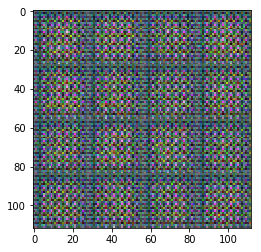

Época 1/1..., etapa 510 Perca do Discriminante: 1.0064... Percado do Gerador: 0.6931
Época 1/1..., etapa 520 Perca do Discriminante: 1.0064... Percado do Gerador: 0.6931
Época 1/1..., etapa 530 Perca do Discriminante: 1.0064... Percado do Gerador: 0.6931
Época 1/1..., etapa 540 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 550 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 560 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 570 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 580 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 590 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 600 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133


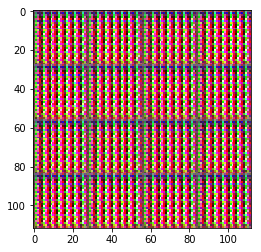

Época 1/1..., etapa 610 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 620 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 630 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 640 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 650 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 660 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 670 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 680 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 690 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 700 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133


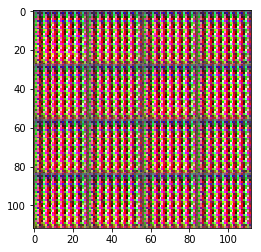

Época 1/1..., etapa 710 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 720 Perca do Discriminante: 1.6267... Percado do Gerador: 0.3133
Época 1/1..., etapa 730 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 740 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 750 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 760 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 770 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 780 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 790 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 800 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133


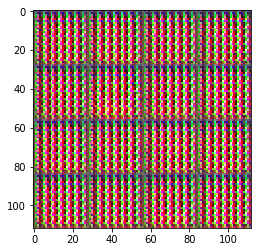

Época 1/1..., etapa 810 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 820 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 830 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 840 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 850 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 860 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 870 Perca do Discriminante: 1.6266... Percado do Gerador: 0.3133
Época 1/1..., etapa 880 Perca do Discriminante: 1.6266... Percado do Gerador: 0.3133
Época 1/1..., etapa 890 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 900 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133


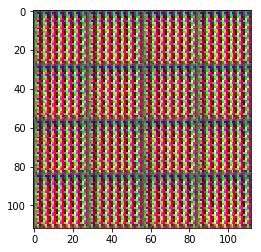

Época 1/1..., etapa 910 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 920 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 930 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 940 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 950 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 960 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 970 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 980 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 990 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 1000 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133


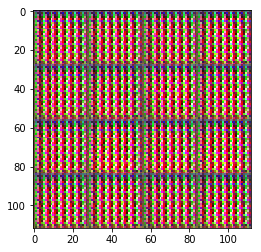

Época 1/1..., etapa 1010 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 1020 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 1030 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 1040 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 1050 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 1060 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 1070 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 1080 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 1090 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 1100 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133


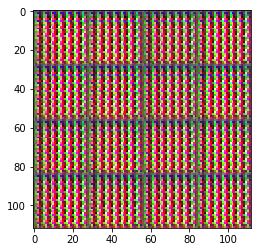

Época 1/1..., etapa 1110 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 1120 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 1130 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 1140 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 1150 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 1160 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 1170 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 1180 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 1190 Perca do Discriminante: 1.6266... Percado do Gerador: 0.3133
Época 1/1..., etapa 1200 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133


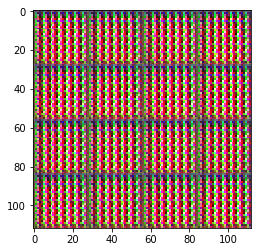

Época 1/1..., etapa 1210 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 1220 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 1230 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 1240 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 1250 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 1260 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 1270 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 1280 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 1290 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 1300 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133


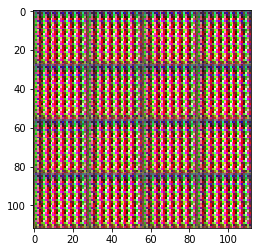

Época 1/1..., etapa 1310 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 1320 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 1330 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 1340 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 1350 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 1360 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 1370 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 1380 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 1390 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 1400 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133


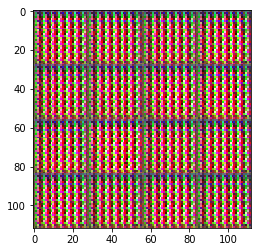

Época 1/1..., etapa 1410 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 1420 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 1430 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 1440 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 1450 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 1460 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 1470 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 1480 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 1490 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 1500 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133


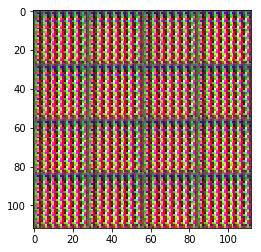

Época 1/1..., etapa 1510 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 1520 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 1530 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 1540 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 1550 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 1560 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 1570 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 1580 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 1590 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 1600 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133


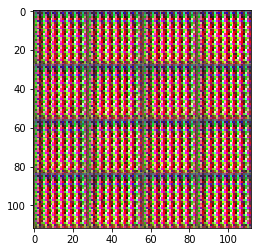

Época 1/1..., etapa 1610 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 1620 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 1630 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 1640 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 1650 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 1660 Perca do Discriminante: 1.6266... Percado do Gerador: 0.3133
Época 1/1..., etapa 1670 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 1680 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 1690 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 1700 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133


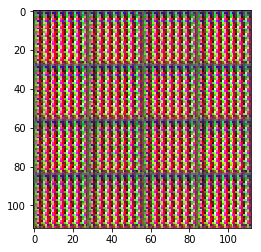

Época 1/1..., etapa 1710 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 1720 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 1730 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 1740 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 1750 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 1760 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 1770 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 1780 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 1790 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 1800 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133


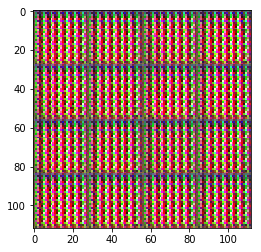

Época 1/1..., etapa 1810 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 1820 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 1830 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 1840 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 1850 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 1860 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 1870 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 1880 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 1890 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 1900 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133


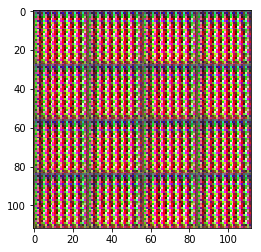

Época 1/1..., etapa 1910 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 1920 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 1930 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 1940 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 1950 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 1960 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 1970 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 1980 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 1990 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 2000 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133


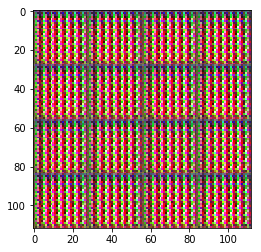

Época 1/1..., etapa 2010 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 2020 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 2030 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 2040 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 2050 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 2060 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 2070 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 2080 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 2090 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 2100 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133


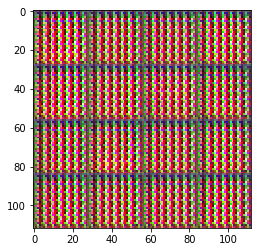

Época 1/1..., etapa 2110 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 2120 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 2130 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 2140 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 2150 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 2160 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 2170 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 2180 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 2190 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 2200 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133


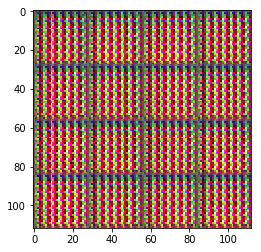

Época 1/1..., etapa 2210 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 2220 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 2230 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 2240 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 2250 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 2260 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 2270 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 2280 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 2290 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 2300 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133


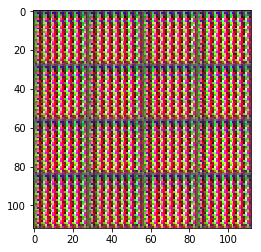

Época 1/1..., etapa 2310 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 2320 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 2330 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 2340 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 2350 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 2360 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 2370 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 2380 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 2390 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 2400 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133


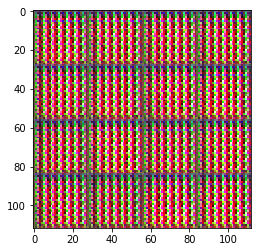

Época 1/1..., etapa 2410 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 2420 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 2430 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 2440 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 2450 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 2460 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 2470 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 2480 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 2490 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 2500 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133


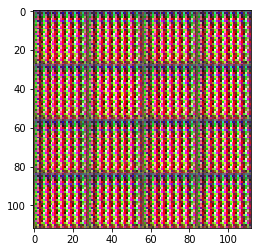

Época 1/1..., etapa 2510 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 2520 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 2530 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 2540 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 2550 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 2560 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 2570 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 2580 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 2590 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 2600 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133


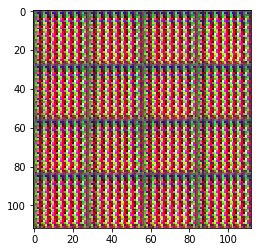

Época 1/1..., etapa 2610 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 2620 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 2630 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 2640 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 2650 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 2660 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 2670 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 2680 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 2690 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 2700 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133


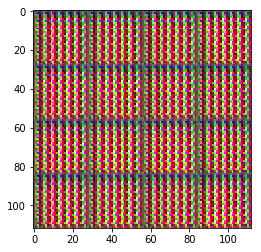

Época 1/1..., etapa 2710 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 2720 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 2730 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 2740 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 2750 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 2760 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 2770 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 2780 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 2790 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 2800 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133


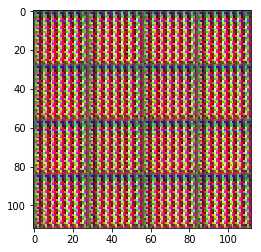

Época 1/1..., etapa 2810 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 2820 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 2830 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 2840 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 2850 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 2860 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 2870 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 2880 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 2890 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 2900 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133


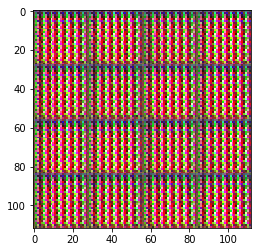

Época 1/1..., etapa 2910 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 2920 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 2930 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 2940 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 2950 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 2960 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 2970 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 2980 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 2990 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 3000 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133


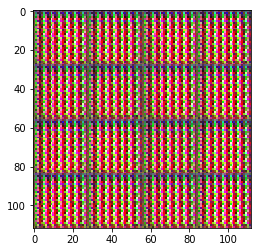

Época 1/1..., etapa 3010 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 3020 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 3030 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 3040 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 3050 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 3060 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 3070 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 3080 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 3090 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 3100 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133


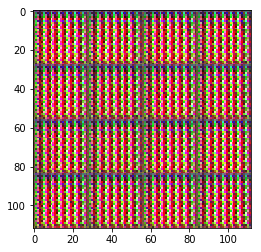

Época 1/1..., etapa 3110 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 3120 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 3130 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 3140 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 3150 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133
Época 1/1..., etapa 3160 Perca do Discriminante: 1.6265... Percado do Gerador: 0.3133


In [30]:
batch_size = 64
z_dim = 100
learning_rate = 0.0003
beta1 = 0.01


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))

with tf.Graph().as_default():
    train(epochs, batch_size, z_dim,
          learning_rate, beta1,
          celeba_dataset.get_batches,
          celeba_dataset.shape,
          celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.